In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill # for loading and saving a trained model
from nowcast_lstm.LSTM import LSTM

# Basic model usage
**\*note*** the model assumes stationary, seasonally adjusted series. So make sure required transformations are already performed by this point. Ideally this means growth rates, as missing values are replaced with 0s. The network may be robust enough to handle first differences or non-stationary levels, but performance in this case is untested.
<br><br>
Data should a dataframe with rows of the highest granularity of data. For example, predicting a yearly variable with monthly, quarterly, and yearly features should have a monthly dataframe. Quarterly variables should be represented as a single value during the period, with missings or 0s in between. E.g. Q1 data would be 0 for January, 0 for February, the value for March, etc. Yearly data would be 0 for January - November, and the value for December.

In [2]:
# data read
data = pd.read_csv("data.csv")
data = data.loc[:, ["x_jp", "x_world", "x_de", "x_uk", "ipi_cn"]] # random subset of columns for simplicity, do NOT include the date column

In [3]:
# training and test datasets
training = data.loc[:len(data)*0.8,:]
test = data.loc[len(data)*0.8:,:]

In [4]:
# instantiating a model with 10 networks based on the previous 12 months with 50 train episodes. See documentation for more information on hyper-parameters.
model = LSTM(data=training, target_variable="x_world", n_timesteps=12, n_models=10, train_episodes=50)

In [5]:
# train the model, quiet=True to suppress printing of training loss
model.train(quiet=True)

Training model 1
Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7
Training model 8
Training model 9
Training model 10


In [6]:
# getting predictions on the train set. To get predictions on periods that don't have an actual value, set drop_missing_ys = False. This will preserve all observations, even if there is no actual, and thus enable prediction on periods in the future.
train_preds = model.predict(model.X)

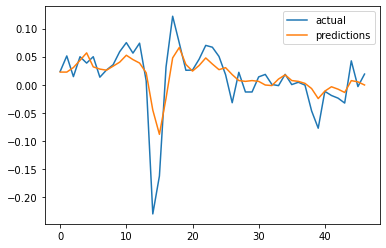

In [7]:
# performance on the train set
plt.plot(model.y, label="actual") 
plt.plot(train_preds, label="predictions")
plt.legend();

In [8]:
# creating a new LSTM object from the test set. This is to generate a dataset of the proper format to be accepted by the model, so needs the same target variable and n_timesteps as the model was trained on.
new_data = LSTM(data=test, target_variable="x_world", n_timesteps=12) 

# getting predictions on the test set
test_preds = model.predict(new_data.X)

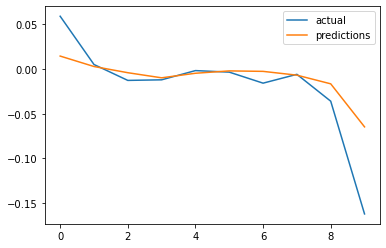

In [9]:
# performance on the test set
plt.plot(new_data.y, label="actual")
plt.plot(test_preds, label="predictions")
plt.legend();

In [10]:
# saving a trained model
dill.dump(model, open("trained_model.pkl", mode='wb'))

In [11]:
# loading a trained model
trained_model = dill.load(open("trained_model.pkl", "rb", -1))

# Realistic model evaluation scenario
The test set above assumes full data for each test observation, this is rarely the case with economic data. The process below outlines how to check the performance of the model on different data vintages, i.e. how the data would have looked at various points in time leading up to the prediction period.

In [12]:
# data read
data = pd.read_csv("data.csv")
data = data.loc[:, ["x_jp", "x_world", "x_de", "x_uk", "ipi_cn"]] # random subset of columns for simplicity

### n_timesteps
This is the number of leading periods that the model will be estimated on, see documentation for more information. Relevant for test/train sets because to have every target observation in the test set, we also need the trailing `n_timesteps-1` rows of data. For example say we have `n_timesteps=12`, i.e. a model based on 1 year history of monthly data, if our train set stops at 2019-12-01, and our test set begins at 2020-01-01, to be able to predict a value for 2020-01-01, we need data back to 2019-02-01 to have a full dataset for that observation.
<br><br>
This `n_timesteps-1` provision can be left out, however. Then the first test observation will be `n_timesteps-1` ahead of the first row of our test data. E.g. in the case mentioned before, 2020-12-01 will be the first test observation we can predict on, as it is the first observation where a full 12 month history exists in our test data starting on 2020-01-01.

In [13]:
# training and test datasets
n_timesteps = 12
n_models = 10
train_row_end = round(len(data)*0.8) # training on 80% of the data
test_row_begin = train_row_end - (n_timesteps - 1)

train = data.loc[:train_row_end,:]
test = data.loc[test_row_begin:,:]

In [14]:
# target column
target = "x_world"

### lags
This is a vector of dimensions 1 x n_features. I.e. the number of independent variables in the model, this means NOT including the target variable. So for a model with a 200 x 10 dataframe, with 200 observations and 10 columns, the lags vector should have 9 entries, one for each variable less the target column.
<br><br>
Its function is to provide the publication lag/schedule for each series to be able to generate data vintages via the `gen_ragged_X` function. The contents should therefore be the number of periods of lag each series experienced when published. For example, if there are three independent variables in a monthly model, GDP, exports, and the business confidence index, and they are published with a 3, 2, and 1 month lag, respectively, the lag vector should read `[3,2,1]`, or in whatever order the columns are in the original dataframe. A lag value of 2 means that if if the current period is June, values are available until March. A lag value of 1 means values are available to April. A lag value of 0 means that if we are in June, May values are already available. A value of 0 does not mean June figures are available, because if we are in June the period is not complete and there can be no data available yet. However, a lag of -1 can be used for this case, e.g. if provisional or forecasted figures are published.
<br><br>
The units of the lag is the units of the original dataframe, i.e. the highest granularity of data. The monthly example above should then be extrapolated for the case of e.g. daily or quarterly data.

In [15]:
# example publication lags. Means x_jp comes out 1 month later, x_de 0 months later, x_uk 2 months later, ipi_cn 3 months later
lags = [1, 0, 2, 3]

In [16]:
# model instantiation and training
model = LSTM(train, target, n_timesteps=n_timesteps, n_models=n_models)
model.train(quiet=True)

Training model 1
Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7
Training model 8
Training model 9
Training model 10


### model assessment on vintages
The first testing example in this notebook made predictions on full datasets, i.e as if the lags for all variables was -1. This is an unrealistic scenario, so a better evaluation of a nowcasting model's performance is testing it on incomplete datasets that reflect real data publication conditions. The code below therefore uses the `lags` vector and the `gen_ragged_X` function to create vintage datasets to test on. The below example will find performance of the model as if predictions were made 1 and 2 months before the target period, in the target period, and 1 and 2 months after the target period. The appropriate prediction periods should be chosen as relevant for the use case of the nowcast. Testing continues after the target period because of publication lags. If we are nowcasting Q2 numbers and are in June, that does not mean that we have full data for June. Some figures from Q2 months may not come out until July or August, therefore the testing on vintages past the target period.

In [17]:
# putting test data into the format required to make predictions
test_data = LSTM(test, target, n_timesteps=n_timesteps, n_models=n_models)

### gen_ragged_X function
This function creates data vintages using a publication schedule, `pub_lags` vector, explained above. The second parameter, `lag`, is the simulated period offset. It can be interpreted as the last completed period relative to the target period. Period-of can be simulated with a value of -1, i.e we are in June, therefore the period before is the last complete period, May. 0 means the period of interest, June, is complete, therefore we are in July, and so on in both directions.
<br><br>
Generally we should expect to see evaluation metrics get better the further ahead in time we move, as more data is available.

In [18]:
# performance on a single vintage, 1 month back of target period
lag = -2 # i.e. we are 1 month back of target period, 2 months ago is the last completed period
prediction_data = test_data.gen_ragged_X(lags, lag)
preds = model.predict(prediction_data)
    
# different evaluation metrics, test_data.y is actuals
RMSE = np.sqrt(np.mean((test_data.y - preds)**2))
MAE = np.mean(np.abs(test_data.y - preds))

print(f"RMSE: {np.round(RMSE, 4)}")
print(f"MAE: {np.round(MAE, 4)}")

RMSE: 0.0289
MAE: 0.0226


In [19]:
# adding back dates to the test set for easier interpretation in plots
dates = pd.read_csv("data.csv", parse_dates=["date"]).loc[:,["date", target]] # dataframe of dates + target variable
dates = dates.loc[(test_row_begin + (n_timesteps-1)):, :].reset_index(drop=True) # get testing subset, undoing provision of n_timesteps-1 rows, because dates in this range don't fall in the test observations due to history required for n_timesteps
dates = dates.loc[~pd.isna(dates[target]),:].reset_index(drop=True) # only keep dates where there was a test observation

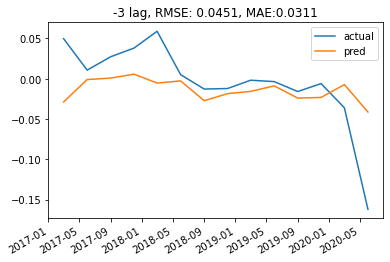

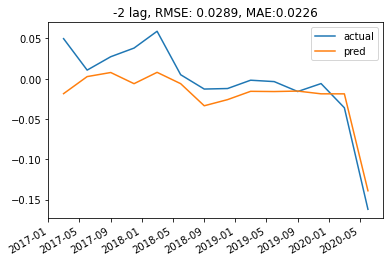

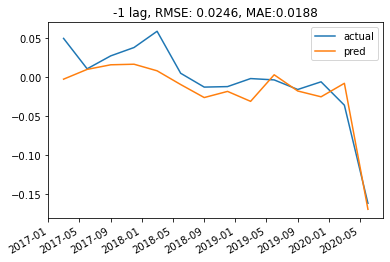

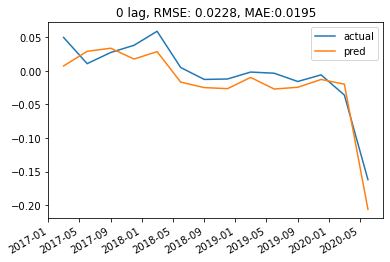

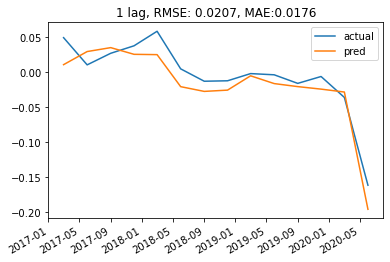

In [20]:
# visualization of performance over time, to see how performance develops
for lag in [-3, -2, -1, 0, 1]: # 2 month back, 1 month back, month-of, 1 month ahead, 2 months ahead vintages
    preds = model.predict(test_data.gen_ragged_X(lags, lag))
    
    # different evaluation metrics, test_data.y is actuals
    RMSE = np.sqrt(np.mean((test_data.y - preds)**2))
    MAE = np.mean(np.abs(test_data.y - preds))
    
    # plotting results
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    
    ax.plot(dates.date, test_data.y, label="actual")
    ax.plot(dates.date, preds, label=f"pred")
    plt.title(f"{lag} lag, RMSE: {np.round(RMSE,4)}, MAE:{np.round(MAE,4)}")
    plt.legend()
    plt.show()